In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
# Change VGG16 import to ResNet50
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping

2025-04-22 01:28:10.872065: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 01:28:10.874539: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 01:28:10.881240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745265490.892173   78923 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745265490.895496   78923 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745265490.904089   78923 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Check if previously saved models exist
cnn_model_path = "glaucoma_cnn_model_acrima.keras"
resnet_model_path = "glaucoma_resnet50_model_acrima.keras"

if os.path.exists(cnn_model_path):
    print("Loading existing CNN model...")
    cnn_model = tf.keras.models.load_model(cnn_model_path)
    SKIP_CNN_TRAINING = True
else:
    print("No existing CNN model found. Will train a new CNN model.")
    SKIP_CNN_TRAINING = False

# Update the model path check for ResNet50
if os.path.exists(resnet_model_path):
    print("Loading existing ResNet50 model...")
    resnet_model = tf.keras.models.load_model(resnet_model_path)
    SKIP_RESNET_TRAINING = True
else:
    print("No existing ResNet50 model found. Will train a new ResNet50 model.")
    SKIP_RESNET_TRAINING = False

No existing CNN model found. Will train a new CNN model.
No existing ResNet50 model found. Will train a new ResNet50 model.


In [3]:
# Set image dimensions - ResNet50 also uses 224x224
img_height, img_width = 224, 224

def load_and_preprocess_dataset(dataset_name, base_path="dataset"):
    """Load and preprocess images from a dataset"""
    images_glaucoma = []
    images_normal = []

    for category, image_list in zip(["glaucoma", "normal"], [images_glaucoma, images_normal]):
        dataset_path = os.path.join(base_path, dataset_name, category)

        if not os.path.exists(dataset_path):
            print(f"Dataset path for {dataset_name}/{category} not found.")
            continue

        image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Load, convert color, resize, and normalize in one step
        image_list.extend([
            cv2.resize(
                cv2.cvtColor(cv2.imread(os.path.join(dataset_path, img_name)), cv2.COLOR_BGR2RGB),
                (img_height, img_width)
            ) / 255.0
            for img_name in image_files
        ])

    print(f"{dataset_name} images loaded and preprocessed successfully.")
    return np.array(images_glaucoma), np.array(images_normal)

In [4]:
def display_dataset_samples(dataset_name, images_glaucoma, images_normal, num_samples=4):
    """Display sample images from each category"""
    categories = ["Glaucoma", "Normal"]
    image_lists = [images_glaucoma, images_normal]

    for category, image_list in zip(categories, image_lists):
        if len(image_list) == 0:
            print(f"No images available for {dataset_name} - {category}")
            continue

        # Randomly select images (avoiding errors if list has fewer images)
        sample_images = random.choices(image_list, k=min(num_samples, len(image_list)))

        print(f"\nSample {dataset_name} {category} images:")
        plt.figure(figsize=(15, 10))

        for i, img in enumerate(sample_images):
            plt.subplot(1, num_samples, i + 1)
            # Since images are already normalized (0-1), we can display them directly
            plt.imshow(img)
            plt.axis("off")

        plt.show()

ACRIMA images loaded and preprocessed successfully.

Sample ACRIMA Glaucoma images:


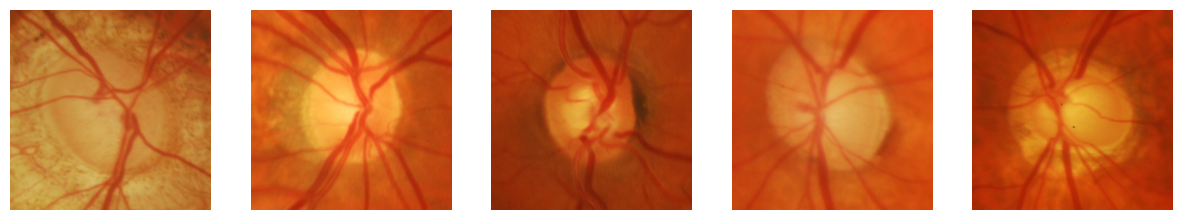


Sample ACRIMA Normal images:


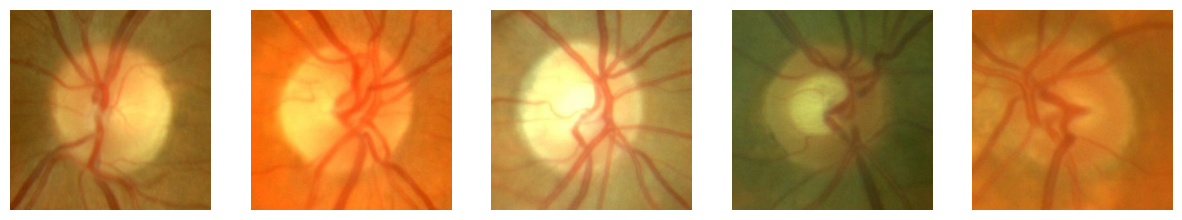

ACRIMA - Glaucoma: (396, 224, 224, 3), Normal: (309, 224, 224, 3)


In [5]:
acrima_glaucoma, acrima_normal = load_and_preprocess_dataset("ACRIMA")
display_dataset_samples("ACRIMA", acrima_glaucoma, acrima_normal, num_samples=5)
print(f"ACRIMA - Glaucoma: {acrima_glaucoma.shape}, Normal: {acrima_normal.shape}")

Total Glaucoma images: 396
Total Normal images: 309
Total images: 705
Total Glaucoma images: 396
Total Normal images: 309


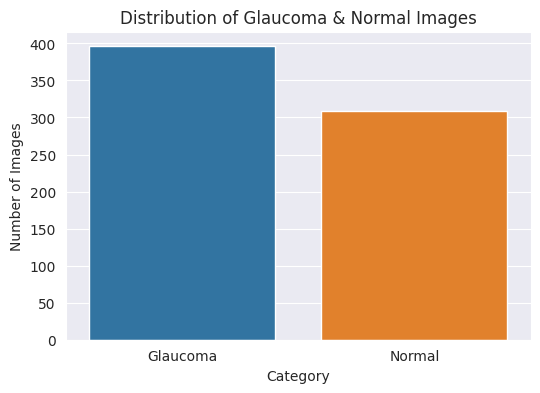

In [6]:
# Print total images in each category
print(f"Total Glaucoma images: {len(acrima_glaucoma)}")
print(f"Total Normal images: {len(acrima_normal)}")

# Define class names and their counts
dataset_classes = np.array(["Glaucoma", "Normal"])
data_count = [len(acrima_glaucoma), len(acrima_normal)]

# Print total counts
print(f"Total images: {sum(data_count)}")
for category, count in zip(dataset_classes, data_count):
    print(f"Total {category} images: {count}")

# Plot class distribution
sns.set_style("darkgrid")
plt.figure(figsize=(6, 4))
sns.barplot(x=dataset_classes, y=data_count, hue=dataset_classes)
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("Distribution of Glaucoma & Normal Images")
plt.show()

In [7]:
# Split data into train, validation and test sets
train_ratio = 0.8
val_ratio = 0.1  # Since test is 10%, val is also 10%

# Splitting Glaucoma images
X_train_glaucoma, temp_glaucoma = train_test_split(acrima_glaucoma, test_size=(1 - train_ratio), random_state=42)
X_val_glaucoma, X_test_glaucoma = train_test_split(temp_glaucoma, test_size=0.5, random_state=42)

# Splitting Normal images
X_train_normal, temp_normal = train_test_split(acrima_normal, test_size=(1 - train_ratio), random_state=42)
X_val_normal, X_test_normal = train_test_split(temp_normal, test_size=0.5, random_state=42)

# Print split counts
print(f"Train - Glaucoma: {len(X_train_glaucoma)}, Normal: {len(X_train_normal)}")
print(f"Validation - Glaucoma: {len(X_val_glaucoma)}, Normal: {len(X_val_normal)}")
print(f"Test - Glaucoma: {len(X_test_glaucoma)}, Normal: {len(X_test_normal)}")

Train - Glaucoma: 316, Normal: 247
Validation - Glaucoma: 40, Normal: 31
Test - Glaucoma: 40, Normal: 31


In [8]:
# Combine datasets and create labels
X_train = np.concatenate((X_train_glaucoma, X_train_normal), axis=0)
y_train = np.concatenate((np.ones(len(X_train_glaucoma)), np.zeros(len(X_train_normal))))

X_val = np.concatenate((X_val_glaucoma, X_val_normal), axis=0)
y_val = np.concatenate((np.ones(len(X_val_glaucoma)), np.zeros(len(X_val_normal))))

X_test = np.concatenate((X_test_glaucoma, X_test_normal), axis=0)
y_test = np.concatenate((np.ones(len(X_test_glaucoma)), np.zeros(len(X_test_normal))))

# Convert to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Define data augmentation (enhanced version for both models)
datagen = ImageDataGenerator(
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Prepare augmentation (required for the generator)
datagen.fit(X_train)

In [10]:
# Create TensorFlow datasets for training, validation, and testing for CNN model
# For training data (with augmentation)
def train_generator_fn(batch_size=32):
    return datagen.flow(X_train, y_train_cat, batch_size=batch_size, shuffle=True)

cnn_train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator_fn(32),
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

# For validation data (NO augmentation)
cnn_val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val_cat)).batch(32).prefetch(tf.data.AUTOTUNE)

# For test data (NO augmentation)
cnn_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat)).batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
if not SKIP_CNN_TRAINING:
    # Define the CNN model
    cnn_model = Sequential()

    # Input Layer
    cnn_model.add(Input(shape=(img_height, img_width, 3)))

    # Convolutional and Pooling Layers (filters increasing deeper)
    cnn_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    cnn_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    cnn_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening Layer
    cnn_model.add(Flatten())

    # Fully Connected Layers
    cnn_model.add(Dense(512, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.4))

    cnn_model.add(Dense(256, activation='relu'))
    cnn_model.add(Dropout(0.4))

    # Output Layer
    cnn_model.add(Dense(units=2, activation='softmax'))  # 2 classes (glaucoma, normal)

    # Compile the model
    cnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    # Model summary
    print("CNN Model Architecture:")
    cnn_model.summary()
else:
    # Just display the model summary
    print("CNN Model Architecture (loaded from disk):")
    cnn_model.summary()

CNN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,848,546 (98.60 MB)

 Trainable params: 25,847,298 (98.60 MB)

 Non-trainable params: 1,248 (4.88 KB)

In [16]:
if not SKIP_CNN_TRAINING:
    # Calculate steps per epoch based on dataset size and batch size
    batch_size = 32
    steps_per_epoch = np.ceil(len(X_train)/batch_size).astype(int)

    # Train the model using tf.data.Dataset
    cnn_history = cnn_model.fit(
        cnn_train_ds,
        steps_per_epoch=steps_per_epoch,
        epochs=150,
        validation_data=cnn_val_ds,
        verbose=1
    )

    # Save the model after training
    cnn_model.save(cnn_model_path)
    print("CNN Model saved!")
else:
    # Create an empty history object to avoid errors in the plotting cell
    class EmptyHistory:
        def __init__(self):
            self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
    cnn_history = EmptyHistory()
    print("Skipped CNN training as model was loaded from disk.")

Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 679ms/step - accuracy: 0.7189 - loss: 0.8632 - val_accuracy: 0.5634 - val_loss: 0.6620
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 670ms/step - accuracy: 0.9283 - loss: 0.1997 - val_accuracy: 0.5634 - val_loss: 0.7469
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 661ms/step - accuracy: 0.9393 - loss: 0.1802 - val_accuracy: 0.5634 - val_loss: 0.9504
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 661ms/step - accuracy: 0.9418 - loss: 0.1798 - val_accuracy: 0.5634 - val_loss: 1.0594
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 668ms/step - accuracy: 0.9583 - loss: 0.1645 - val_accuracy: 0.5634 - val_loss: 1.3496
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 665ms/step - accuracy: 0.9505 - loss: 0.1370 - val_accuracy: 0.5634 - val_loss: 1.4515
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 665ms/step - accuracy: 0.9434 - loss: 0.1433 - val_accuracy: 0.5634 - val_loss: 1.6189
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 654ms/step - accuracy: 0.9449 - loss: 0.1329 - 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9891 - loss: 0.0314
CNN Test accuracy: 0.9859


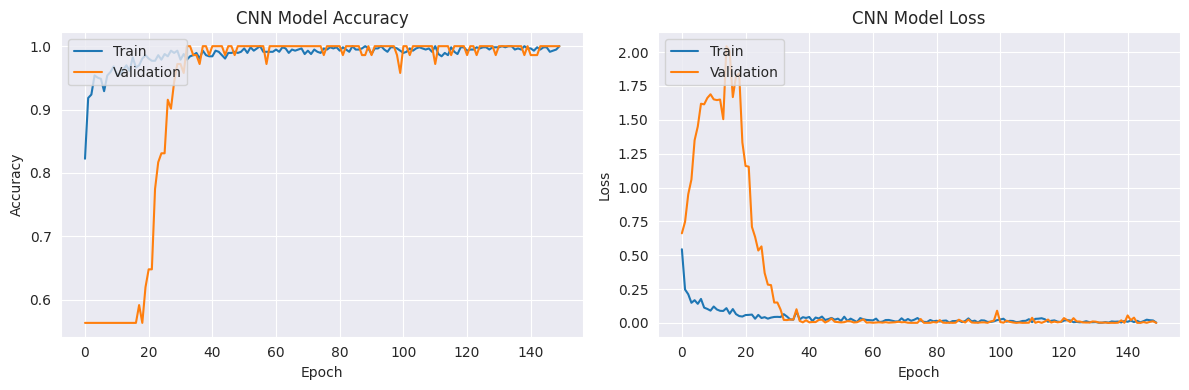

In [17]:
# Evaluate the CNN model on the test set
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(cnn_test_ds)
print(f"CNN Test accuracy: {cnn_test_accuracy:.4f}")

# Plot CNN training history if available
if not SKIP_CNN_TRAINING:
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(cnn_history.history['accuracy'])
    plt.plot(cnn_history.history['val_accuracy'])
    plt.title('CNN Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(cnn_history.history['loss'])
    plt.plot(cnn_history.history['val_loss'])
    plt.title('CNN Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()
else:
    print("Training history not available for loaded CNN model.")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


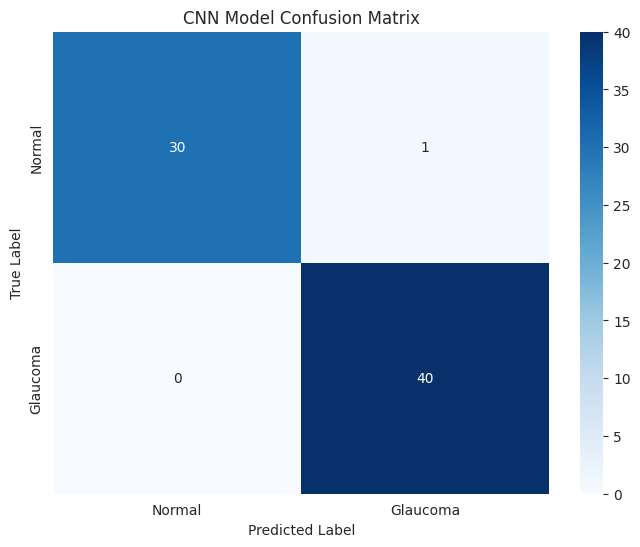

In [18]:
# Get predictions using the CNN test dataset
cnn_y_pred = cnn_model.predict(cnn_test_ds)
cnn_predicted_classes = np.argmax(cnn_y_pred, axis=1)
true_classes = np.argmax(y_test_cat, axis=1)

# Calculate and display confusion matrix for CNN
cnn_cm = confusion_matrix(true_classes, cnn_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Glaucoma'], yticklabels=['Normal', 'Glaucoma'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN Model Confusion Matrix')
plt.show()

In [19]:
# Display classification report for CNN
print("CNN Classification Report:")
print(classification_report(true_classes, cnn_predicted_classes, target_names=['Normal', 'Glaucoma']))

CNN Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98        31
    Glaucoma       0.98      1.00      0.99        40

    accuracy                           0.99        71
   macro avg       0.99      0.98      0.99        71
weighted avg       0.99      0.99      0.99        71



In [11]:
# Create TensorFlow datasets for training, validation, and testing for ResNet50 model
# For training data (with augmentation)
resnet_train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator_fn(16),  # Smaller batch size for ResNet50
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

# For validation and test data (NO augmentation)
resnet_val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val_cat)).batch(16).prefetch(tf.data.AUTOTUNE)
resnet_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat)).batch(16).prefetch(tf.data.AUTOTUNE)

In [12]:
if not SKIP_RESNET_TRAINING:
    # Load pre-trained ResNet50 model (without top classification layers)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

    # Freeze the convolutional base
    base_model.trainable = False

    # Create a new model on top of the base model
    inputs = Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Use global average pooling 

    # Add classification layers
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)

    # Output layer
    outputs = Dense(2, activation='softmax')(x)

    # Create the transfer learning model
    resnet_model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    resnet_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Model summary
    print("ResNet50 Transfer Learning Model Architecture:")
    resnet_model.summary()

    # Calculate steps per epoch based on dataset size and batch size
    batch_size = 16  # Using smaller batch size for ResNet50 training
    steps_per_epoch = np.ceil(len(X_train)/batch_size).astype(int)

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=0.001,
        mode='min',
        restore_best_weights=True
    )

    # Initial training phase with frozen base model
    print("Phase 1: Training only the top layers...")
    history_phase1 = resnet_model.fit(
        resnet_train_ds,
        steps_per_epoch=steps_per_epoch,
        epochs=15,  # Start with fewer epochs
        validation_data=resnet_val_ds,
        verbose=1,
        callbacks=[early_stopping] 
    )

    # Fine-tuning phase - unfreeze the last few layers of the base model
    print("Phase 2: Fine-tuning the model...")
    # Unfreeze the last 4 convolutional layers of ResNet50
    # ResNet50 has different layer structure than VGG16, so we're unfreezing the last few layers
    for layer in base_model.layers[-15:]:  # Adjusted for ResNet50 architecture
        layer.trainable = True

    # Recompile model with a lower learning rate for fine-tuning
    resnet_model.compile(
        optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Continue training with unfrozen layers
    history_phase2 = resnet_model.fit(
        resnet_train_ds,
        steps_per_epoch=steps_per_epoch,
        epochs=50,  # Train for more epochs during fine-tuning
        validation_data=resnet_val_ds,
        verbose=1,
        callbacks=[early_stopping] 
    )

    # Combine histories for plotting
    combined_history = {}
    combined_history['accuracy'] = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
    combined_history['val_accuracy'] = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
    combined_history['loss'] = history_phase1.history['loss'] + history_phase2.history['loss']
    combined_history['val_loss'] = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

    resnet_history = type('obj', (object,), {'history': combined_history})

    # Save the model after training
    resnet_model.save(resnet_model_path)
    print("ResNet50 Model saved!")
else:
    # Create an empty history object to avoid errors in the plotting cell
    class EmptyHistory:
        def __init__(self):
            self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
    resnet_history = EmptyHistory()
    print("Skipped ResNet50 training as model was loaded from disk.")

ResNet50 Transfer Learning Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,770,690 (94.49 MB)

 Trainable params: 1,181,954 (4.51 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

Phase 1: Training only the top layers...
Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 432ms/step - accuracy: 0.5781 - loss: 0.6755 - val_accuracy: 0.4366 - val_loss: 0.9975
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 390ms/step - accuracy: 0.7372 - loss: 0.5722 - val_accuracy: 0.4366 - val_loss: 1.1064
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 401ms/step - accuracy: 0.7820 - loss: 0.4877 - val_accuracy: 0.4366 - val_loss: 1.2151
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 405ms/step - accuracy: 0.8144 - loss: 0.4524 - val_accuracy: 0.4366 - val_loss: 1.0029
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step - accuracy: 0.8376 - loss: 0.4115 - val_accuracy: 0.4366 - val_loss: 0.8224
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 405ms/step - accuracy: 0.8372 - loss: 0.3944 - val_accuracy: 0.4366 - val_loss: 0.7210
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 405ms/step - accuracy: 0.8495 - loss: 0.3948 - val_accuracy: 0.7324 - val_loss: 0.6495
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step - a

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - accuracy: 0.9819 - loss: 0.1110
ResNet50 Test accuracy: 0.9718


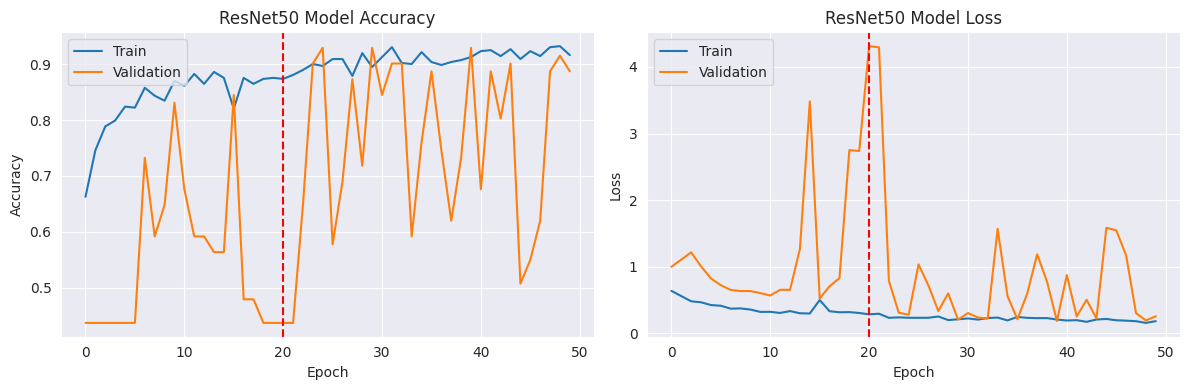

In [13]:
# Evaluate the ResNet50 model on the test set
resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(resnet_test_ds)
print(f"ResNet50 Test accuracy: {resnet_test_accuracy:.4f}")

# Plot ResNet50 training history if available
if not SKIP_RESNET_TRAINING:
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(resnet_history.history['accuracy'])
    plt.plot(resnet_history.history['val_accuracy'])
    plt.title('ResNet50 Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.axvline(x=20, color='r', linestyle='--')  # Mark where fine-tuning began
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(resnet_history.history['loss'])
    plt.plot(resnet_history.history['val_loss'])
    plt.title('ResNet50 Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.axvline(x=20, color='r', linestyle='--')  # Mark where fine-tuning began
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()
else:
    print("Training history not available for loaded ResNet50 model.")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step


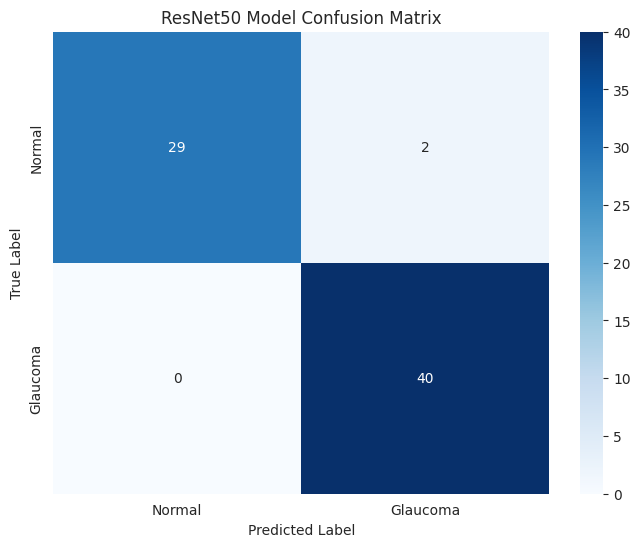

In [20]:
# Get predictions using the ResNet50 test dataset
resnet_y_pred = resnet_model.predict(resnet_test_ds)
resnet_predicted_classes = np.argmax(resnet_y_pred, axis=1)

# Calculate and display confusion matrix for ResNet50
resnet_cm = confusion_matrix(true_classes, resnet_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(resnet_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Glaucoma'], yticklabels=['Normal', 'Glaucoma'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ResNet50 Model Confusion Matrix')
plt.show()

In [21]:
# Display classification report for ResNet50
print("ResNet50 Classification Report:")
print(classification_report(true_classes, resnet_predicted_classes, target_names=['Normal', 'Glaucoma']))

ResNet50 Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.94      0.97        31
    Glaucoma       0.95      1.00      0.98        40

    accuracy                           0.97        71
   macro avg       0.98      0.97      0.97        71
weighted avg       0.97      0.97      0.97        71

